In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']
# matplotlib.rc('pdf', fonttype=42)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import itertools

In [5]:
# Ground truth MDP model
MDP_parameters = joblib.load('../data/MDP_parameters.joblib')
P = MDP_parameters['transition_matrix_absorbing'] # (A, S, S_next)
R = MDP_parameters['reward_matrix_absorbing_SA'] # (S, A)
nS, nA = R.shape
gamma = 0.99

# unif rand isd, mixture of diabetic state
PROB_DIAB = 0.2
isd = joblib.load('../data/modified_prior_initial_state_absorbing.joblib')
isd = (isd > 0).astype(float)
isd[:720] = isd[:720] / isd[:720].sum() * (1-PROB_DIAB)
isd[720:] = isd[720:] / isd[720:].sum() * (PROB_DIAB)

# Optimal value function and optimal return
V_star = joblib.load('../data/V_π_star_PE.joblib')
J_star = V_star @ isd

In [6]:
num_runs = 10

In [7]:
to_plot = 'Regret'

In [8]:
layers_list = [1, 2]
units_list = [100, 200, 500, 1000]
lr_list = [1e-3, 1e-4]
k_list = [1, 2, 4, 8, 16, 32]

In [9]:
keys = [str((nl, nh, lr, k)) for nl, nh, lr, k in itertools.product(layers_list, units_list, lr_list, k_list)]

In [10]:
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(matplotlib.colors.to_rgb(c1))
    c2=np.array(matplotlib.colors.to_rgb(c2))
    return matplotlib.colors.to_hex((1-mix)*c1 + mix*c2)

In [12]:
dfs_results_va10k = [pd.read_csv('../exp--main/results/run{}/sepsis-cont-HP-va.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_values_va10k = [pd.read_csv('../exp--main/results/run{}/sepsis-cont-HP-va.values.csv'.format(run)).set_index('(nl, nh, lr, k)').loc[keys] for run in range(num_runs)]

In [48]:
r = 0
df_r = dfs_values_va10k[r]
true_value_list = df_r['true_value_list']
WIS_value_list = df_r['WIS_value_list']
regret_list = true_value_list.max() - true_value_list

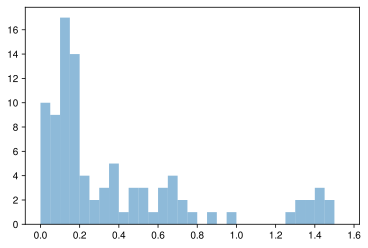

In [144]:
plt.hist(regret_list, bins=np.arange(0, 1.6, 0.05), alpha=0.5)
plt.show()

In [145]:
def prob(C, A, B):
    if A == 0:
        return 0
    elif B == 0:
        return 1
    elif A + B > C:
        return 1
    else:
        return 1 - np.math.factorial(C-A)*np.math.factorial(C-B)/np.math.factorial(C)/np.math.factorial(C-A-B)

In [169]:
K = 96
alphas = np.arange(0,97).astype(int)
betas = [1, 5, 10, 20]

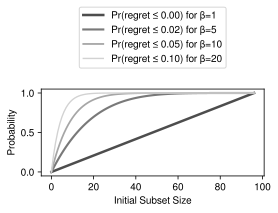

In [247]:
fig, ax = plt.subplots(figsize=(4,1.6))
for i, beta in enumerate(betas):
    probs = [prob(K, alpha, beta) for alpha in alphas]
    plt.plot(alphas, probs, '-', lw=2.5-1.5*i/4, c=colorFader('w', 'k', 1-(0.3+0.7*i/4)), label='Pr(regret ≤ {:.2f}) for β={}'.format(sorted(regret_list)[beta-1], beta))

plt.legend(bbox_to_anchor=(0.5, 2), loc='upper center')
plt.xlabel('Initial Subset Size')
plt.ylabel('Probability')
plt.savefig('fig/cdf_random.pdf', bbox_inches='tight')
plt.show()

In [180]:
WIS_regrets_alphas_list = []
for r in range(num_runs):
    df_r = dfs_values_va10k[r]
    true_value_list = df_r['true_value_list']
    WIS_value_list = df_r['WIS_value_list']
    regrets = [true_value_list.max() - true_value_list[np.argsort(WIS_value_list)[-alpha:]].max() for alpha in alphas[1:]]
    WIS_regrets_alphas_list.append(regrets)

WIS_regrets_alphas_list = np.array(WIS_regrets_alphas_list).T

In [181]:
FQE_regrets_alphas_list = []
for r in range(num_runs):
    df_r = dfs_values_va10k[r]
    true_value_list = df_r['true_value_list']
    FQE_value_list = df_r['FQE_value_list']
    regrets = [true_value_list.max() - true_value_list[np.argsort(FQE_value_list)[-alpha:]].max() for alpha in alphas[1:]]
    FQE_regrets_alphas_list.append(regrets)

FQE_regrets_alphas_list = np.array(FQE_regrets_alphas_list).T

In [191]:
random_cdf_probs = np.array([[prob(K, alpha, beta) for alpha in alphas] for beta in betas])
WIS_cdf_probs = np.array([[0] + [(WIS_regrets_alphas_list[alpha-1, :] <= sorted(regret_list)[beta-1]).mean() for alpha in alphas[1:]] for beta in betas])
FQE_cdf_probs = np.array([[0] + [(FQE_regrets_alphas_list[alpha-1, :] <= sorted(regret_list)[beta-1]).mean() for alpha in alphas[1:]] for beta in betas])

In [192]:
WIS_cdf_probs.shape

(4, 97)

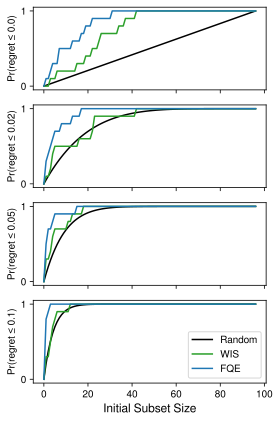

In [245]:
fig, axes = plt.subplots(4, 1, figsize=(4,6), sharex=True)
for i, beta in enumerate(betas):
    plt.sca(axes[i])
    plt.plot(alphas, random_cdf_probs[i], '-', c='k', label='Random')
    plt.plot(alphas, WIS_cdf_probs[i], '-', c='tab:green', label='WIS')
    plt.plot(alphas, FQE_cdf_probs[i], '-', c='tab:blue', label='FQE')
    plt.ylabel('Pr(regret ≤ {})'.format(round(sorted(regret_list)[beta-1], 2)))
    plt.yticks([0,1])

plt.legend(loc='lower right')
plt.xlabel('Initial Subset Size', fontsize=12)
# fig.supylabel('            Probability')
plt.tight_layout()
plt.savefig('fig/cdf_random_WIS_OPE.pdf')
plt.show()

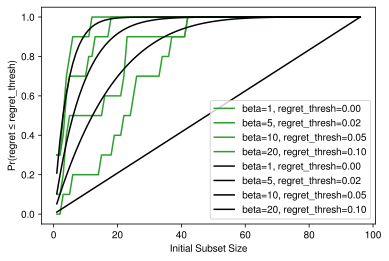

In [103]:
for i, beta in enumerate(betas):
    plt.plot(alphas, WIS_cdf_probs.T[i], '-', c='tab:green', label='beta={}, regret_thresh={:.2f}'.format(beta, sorted(regret_list)[beta-1]))

# plt.legend()
# plt.xlabel('Initial Subset Size')
# plt.ylabel('Pr(regret ≤ regret_thresh)')
# plt.show()

for i, beta in enumerate(betas):
    probs = [prob(K, alpha, beta) for alpha in alphas]
    plt.plot(alphas, probs, '-', c='k', label='beta={}, regret_thresh={:.2f}'.format(beta, sorted(regret_list)[beta-1]))

plt.legend()
plt.xlabel('Initial Subset Size')
plt.ylabel('Pr(regret ≤ regret_thresh)')
plt.show()

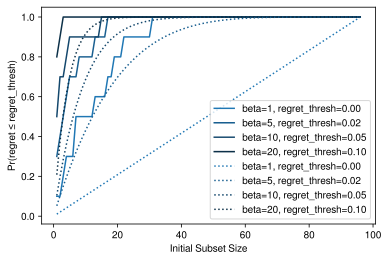

In [105]:
for i, beta in enumerate(betas):
    plt.plot(alphas, FQE_cdf_probs.T[i], '-', c=colorFader('tab:blue', 'black', i/5), label='beta={}, regret_thresh={:.2f}'.format(beta, sorted(regret_list)[beta-1]))

# plt.legend()
# plt.xlabel('Initial Subset Size')
# plt.ylabel('Pr(regret ≤ regret_thresh)')
# plt.show()

for i, beta in enumerate(betas):
    probs = [prob(K, alpha, beta) for alpha in alphas]
    plt.plot(alphas, probs, ':', c=colorFader('tab:blue', 'black', i/5), label='beta={}, regret_thresh={:.2f}'.format(beta, sorted(regret_list)[beta-1]))

plt.legend()
plt.xlabel('Initial Subset Size')
plt.ylabel('Pr(regret ≤ regret_thresh)')
plt.show()